# Which Hard Drives are Most Reliable? 

## Plan


The goal of our project is to determine which hard drives are most reliable by classifying and predicting early hard drive failures. 

Hypotheses:
- The 5 SMART (Self-Monitoring, Analysis and Reporting Technology) stats identified by Backblaze will indicate device hard drive failure
- Hard drive early fail rates will vary by model 
- Hard drive early fail rates will vary by manufacturer 
- Hard drive early fail rates will vary by capacity size

In [1]:
# data wrangling
import pandas as pd
import numpy as np

# visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# py files
import acquire
import prepare
import explore
import model

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

## Acquire

The raw data is available on Backblaze.com. For this analysis, the hard drive data from 2016 - 2019 is utilized. The files are downloaded to a local computer and then unzipped. The files are renamed to the format, "data_Qx_201x", and placed in a folder titled "data". 

The `acquire.acquire_agg_data` function reads in the data, aggregates it, and returns a Pandas dataframe. 
- Using Spark, a dataframe is created from each directory of csv files. The dataframes are concated together with their common columns. This gives a dataframe with 95 columns and 121,390,247 rows. 
- Backblaze identifies 5 SMART stats that predict hard drive failure (SMART 5, 187, 188, 197, 198). The max value of each of these stats are extracted and the dataframe is aggregated by serial number. This reduces the dataframe to 9 columns and 169,073 rows. 
- The spark dataframe is converted to a Pandas dataframe 
- The Pandas dataframe is saved as "hard_drives_smart_5.csv" for future use

This csv is linked in the README and can be downloaded. If "hard_drives_smart_5.csv" is in the working directory, `acquire.acquire_agg_data` will read from the csv instead recreating the dataframe.  

In [2]:
df = acquire.acquire_agg_data()

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169073 entries, 0 to 169072
Data columns (total 10 columns):
serial_number         169072 non-null object
model                 169073 non-null object
capacity_bytes        169073 non-null int64
max(failure)          169073 non-null int64
max(smart_9_raw)      161975 non-null float64
max(smart_5_raw)      161851 non-null float64
max(smart_187_raw)    104189 non-null float64
max(smart_188_raw)    104179 non-null float64
max(smart_197_raw)    161841 non-null float64
max(smart_198_raw)    161841 non-null float64
dtypes: float64(6), int64(2), object(2)
memory usage: 12.9+ MB


In [4]:
df.head()

,serial_number,model,capacity_bytes,max(failure),max(smart_9_raw),max(smart_5_raw),max(smart_187_raw),max(smart_188_raw),max(smart_197_raw),max(smart_198_raw)
0,PL1311LAG1SJAA,Hitachi HDS5C4040ALE630,4000787030016,0,43819.0,0.0,NaN,NaN,0.0,0.0
1,Z305KB36,ST4000DM000,4000787030016,0,31045.0,0.0,0.0,0.0,0.0,0.0
2,MJ0351YNG9MZXA,Hitachi HDS5C3030ALA630,3000592982016,0,41668.0,0.0,NaN,NaN,0.0,0.0
3,ZA11NHSN,ST8000DM002,8001563222016,0,26284.0,0.0,0.0,0.0,0.0,0.0
4,MJ1311YNG2ZSEA,Hitachi HDS5C3030ALA630,3000592982016,0,47994.0,0.0,NaN,NaN,0.0,0.0


In [5]:
df.describe()

,capacity_bytes,max(failure),max(smart_9_raw),max(smart_5_raw),max(smart_187_raw),max(smart_188_raw),max(smart_197_raw),max(smart_198_raw)
count,1.690730e+05,169073.000000,161975.000000,161851.000000,104189.000000,1.041790e+05,161841.000000,161841.000000
mean,6.829480e+12,0.035085,23858.714839,69.851802,5.996190,3.264823e+08,6.265940,5.913261
std,3.981103e+12,0.183996,13357.230448,1393.236993,541.364663,3.014661e+10,452.148242,447.550251
min,-1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
25%,4.000787e+12,0.000000,13727.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
50%,4.000787e+12,0.000000,22932.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
75%,1.200014e+13,0.000000,34866.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
max,1.400052e+13,1.000000,90477.000000,65392.000000,65535.000000,8.933668e+12,142616.000000,142616.000000


## Prepare

The `prepare.prepare` function reads in the dataframe and applies the following changes:
- Converts capacity column from bytes to terabytes.
- Converts max(smart_9_raw) from hours to years.
- Creates a new column for manufacturer name.
- Renames all columns appropriately.
- Reorders columns for understandability. 

In [6]:
df = prepare.prepare(df)

In [7]:
df.head()

,serial_number,manufacturer,model,capacity_terabytes,failure,drive_age_in_years,reallocated_sectors_count,reported_uncorrectable_errors,command_timeout,current_pending_sector_count,uncorrectable_sector_count
0,PL1311LAG1SJAA,Hitachi,Hitachi HDS5C4040ALE630,4.0,0,5.0,0.0,NaN,NaN,0.0,0.0
1,Z305KB36,Seagate,ST4000DM000,4.0,0,3.5,0.0,0.0,0.0,0.0,0.0
2,MJ0351YNG9MZXA,Hitachi,Hitachi HDS5C3030ALA630,3.0,0,4.8,0.0,NaN,NaN,0.0,0.0
3,ZA11NHSN,Seagate,ST8000DM002,8.0,0,3.0,0.0,0.0,0.0,0.0,0.0
4,MJ1311YNG2ZSEA,Hitachi,Hitachi HDS5C3030ALA630,3.0,0,5.5,0.0,NaN,NaN,0.0,0.0


In [8]:
df.capacity_terabytes.value_counts()

 4.0     64886
 12.0    50729
 8.0     26108
-0.0      7031
 3.0      6789
 2.0      4678
 0.5      2607
 6.0      2411
 14.0     1302
 10.0     1255
 1.0       388
 0.3       327
 1.5       267
 0.2       210
 5.0        46
 0.1        39
Name: capacity_terabytes, dtype: int64

> Due to aggregation, we have 7,031 duplicate hard drives listed with zero capacity bytes. 

The `prepare.unique` function reads in the dataframe and removes duplicated serial numbers that were created during aggregation.

In [9]:
df = prepare.unique(df)

In [10]:
# Confirm duplicate hard drives with zero capacity have been removed
df.capacity_terabytes.value_counts()

4.0     64878
12.0    50729
8.0     26106
3.0      6789
2.0      4678
0.5      2607
6.0      2411
14.0     1302
10.0     1255
1.0       388
0.3       327
1.5       267
0.2       210
5.0        46
0.1        32
Name: capacity_terabytes, dtype: int64

## Explore

Questions to answer:
- How do we treat null values?
- What does our data look like?
    - How many different models?
    - How many different capacity sizes?
    - How many different manufacturers?
    - How many hard drives are there for each manufacturer?
    - How many models are there for each manufacturer?
    - Are model numbers unique to capacity?
- What is a failure?
    - What do failures look like?
    - How do lifespans of hard drives compare to failure rates?
    - How is this misleading?
- How do we define an early failure?
- How do SMART stats values compare to among fail and non-fail?
- Does the average age of drive vary by manufacturer? model number?
- Does capacity size correlate with early failure?
- Do early failure rates vary by model number?
- Which SMART attributes correlate most strongly with early failure? 
- Does the hard drive model affect early failure rate? 

### How do we treat null values?

In [11]:
# Check for null values
df.isnull().sum()

serial_number                        1
manufacturer                         0
model                                0
capacity_terabytes                   0
failure                              0
drive_age_in_years                  60
reallocated_sectors_count          184
reported_uncorrectable_errors    57839
command_timeout                  57849
current_pending_sector_count       194
uncorrectable_sector_count         194
dtype: int64

In [12]:
df.columns

Index(['serial_number', 'manufacturer', 'model', 'capacity_terabytes',
       'failure', 'drive_age_in_years', 'reallocated_sectors_count',
       'reported_uncorrectable_errors', 'command_timeout',
       'current_pending_sector_count', 'uncorrectable_sector_count'],
      dtype='object')

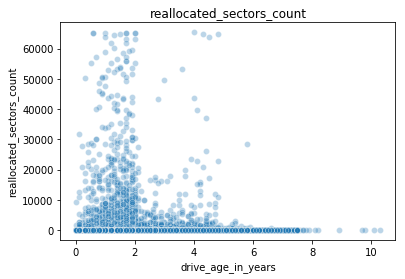

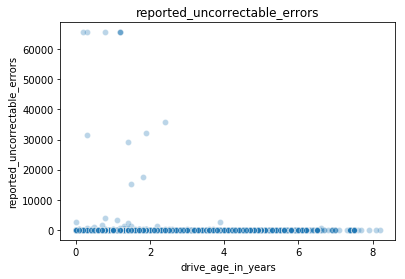

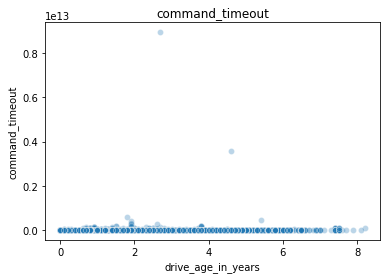

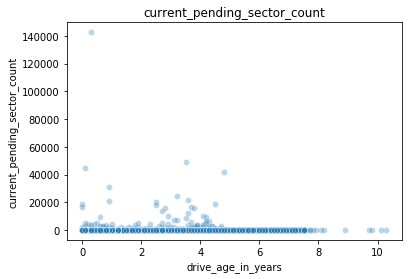

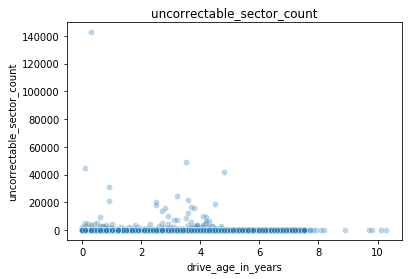

In [13]:
# Create scatterplot for SMART attributes
for col in df.columns[6:]:
    sns.scatterplot(data=df, y=df[col], x=df.drive_age_in_years, alpha=.3)
    plt.title(col)
    plt.show()

> For both "reported_uncorrectable_errors" and "command_timeout" the vast majority of values are zero. Therefore, the nulls in these columns are replaced with zeros. For the remaining nulls in "reallocated_sectors_count", "current_pending_sector_count" and "uncorrecteable_sector_count", there are less than 200 for each respective column. Therefore, those rows containing nulls are removed. This is performed in the `prepare.treat_nulls` function.

In [14]:
df = prepare.treat_nulls(df)

In [15]:
# Confirm all nulls have been removed 
df.isnull().sum()

serial_number                    0
manufacturer                     0
model                            0
capacity_terabytes               0
failure                          0
drive_age_in_years               0
reallocated_sectors_count        0
reported_uncorrectable_errors    0
command_timeout                  0
current_pending_sector_count     0
uncorrectable_sector_count       0
dtype: int64

In [16]:
df.shape

(161830, 11)

> After treating all nulls, the dataframe has 11 columns and 161,830 rows. The data can be further explored. 

### What does our data look like?

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 161830 entries, 0 to 169067
Data columns (total 11 columns):
serial_number                    161830 non-null object
manufacturer                     161830 non-null object
model                            161830 non-null object
capacity_terabytes               161830 non-null float64
failure                          161830 non-null int64
drive_age_in_years               161830 non-null float64
reallocated_sectors_count        161830 non-null float64
reported_uncorrectable_errors    161830 non-null float64
command_timeout                  161830 non-null float64
current_pending_sector_count     161830 non-null float64
uncorrectable_sector_count       161830 non-null float64
dtypes: float64(7), int64(1), object(3)
memory usage: 14.8+ MB


#### How many different hard drive models in our dataset? Which are the 5 most popular?

In [18]:
df.model.nunique()

97

In [19]:
df['model'].value_counts().head()

ST12000NM0007           38271
ST4000DM000             36156
HGST HMS5C4040BLE640    16314
ST8000NM0055            14810
HGST HUH721212ALN604    10875
Name: model, dtype: int64

> 97 unique hard drive models. Top 5 hard drive models include 3 Seagate and 2 Hitachi.

#### How many different capacity sizes exist for the hard drives in our dataset?

In [20]:
df.capacity_terabytes.nunique()

15

> 15 unique hard drive capacity sizes after rounding to the nearest tenth of a terabyte.

In [21]:
df.capacity_terabytes.unique()

array([ 4. ,  3. ,  8. ,  0.5,  6. ,  2. ,  1. ,  0.1, 12. , 10. , 14. ,
        1.5,  0.2,  0.3,  5. ])

In [22]:
df.capacity_terabytes.value_counts()

4.0     64877
12.0    50729
8.0     26106
3.0      6789
2.0      4675
0.5      2529
6.0      2411
14.0     1302
10.0     1255
1.0       378
1.5       267
0.3       224
0.2       210
5.0        46
0.1        32
Name: capacity_terabytes, dtype: int64

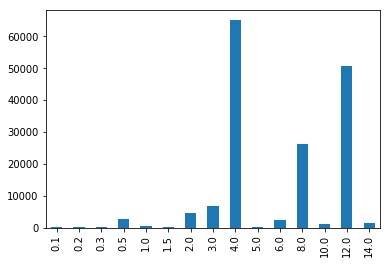

In [23]:
df.capacity_terabytes.value_counts().sort_index().plot.bar()
plt.show()

#### How many different manufacturers are included in our data set?

In [24]:
df.manufacturer.nunique()

6

In [25]:
df.manufacturer.unique()

array(['Hitachi', 'Seagate', 'Western Digital', 'Toshiba', 'Unknown',
       'Samsung'], dtype=object)

> 6 unique manufacturers exist: Hitachi, Seagate, Western Digital, Toshiba, Unknown, and Samsung.

#### How many hard drives exist for each manufacturer?

In [26]:
df[['model', 'manufacturer']].groupby('manufacturer').count()

,model
manufacturer,
Hitachi,51417
Samsung,1
Seagate,105012
Toshiba,2573
Unknown,1
Western Digital,2826


> Seagate and Hitachi are the most popular manufacturers. Samsung and Unknown only have 1 hard drive each. These hard drives should be dropped from our dataset. 

The `explore.remove_manufacturer` function reads in the dataframe and removes the two manufacturers with low value counts.

In [27]:
df = explore.remove_manufacturers(df)

In [28]:
# Confirm low count manufacturers have been removed
df[['model', 'manufacturer']].groupby('manufacturer').count()

,model
manufacturer,
Hitachi,51417
Seagate,105012
Toshiba,2573
Western Digital,2826


#### How many models per manufacturer? 

In [29]:
df.groupby('model').agg({'manufacturer': 'max'}).manufacturer.value_counts()

Western Digital    37
Seagate            31
Hitachi            19
Toshiba             8
Name: manufacturer, dtype: int64

> Western Digital has the most diversity of models.

#### Are model numbers unique to capacity?

In [30]:
# create new df to group models with their capacity terabytes
model_terabytes = df[['model', 'capacity_terabytes']]

In [31]:
# count unique models
model_terabytes.model.nunique()

95

In [32]:
# group unique model and unique terabytes combinations
unique_model_terabytes = len(model_terabytes.groupby(['model', 'capacity_terabytes']).count())

In [33]:
# compare the length of unique model and gigabytes combinations to the count of unique models, must equal a match.
unique_model_terabytes == model_terabytes.model.nunique()

True

> Yes, model numbers are unique to capacity. We ask this question to ensure there are not any hard drive models that have different capacities. 

#### Does the average hard drive age vary by manufacturer? By model?

In [34]:
# Average drive age by manufacturer
manufacturers = df[['manufacturer', 'drive_age_in_years']].groupby('manufacturer',sort=True).mean()
manufacturers

,drive_age_in_years
manufacturer,
Hitachi,3.057432
Seagate,2.557938
Toshiba,1.611698
Western Digital,3.765322


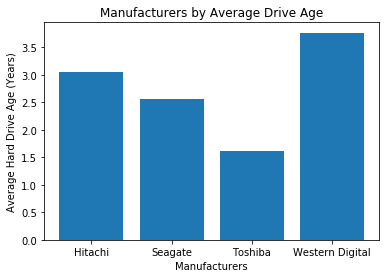

In [35]:
# Plot of Manufacturers by Average Drive Age
ax1 = plt.bar(x= manufacturers.index ,height=manufacturers.drive_age_in_years)
plt.xlabel('Manufacturers')
plt.ylabel('Average Hard Drive Age (Years)')
plt.title('Manufacturers by Average Drive Age')
plt.show()

In [36]:
# Drive age aggregated by model number and sorted. Top 10 models returned
model_avg_age = df[['model', 'drive_age_in_years']].groupby('model',sort=True).mean().sort_values('drive_age_in_years', ascending = False)
model_avg_age.head()

,drive_age_in_years
model,
WDC WD800LB,10.300000
WDC WD800BB,9.240000
Hitachi HDT725025VLA380,7.800000
WDC WD3200AAKS,6.800000
WDC WD10EACS,6.586667


Text(0.5,1,'Models by Average Drive Age')

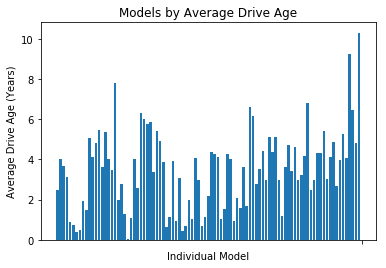

In [37]:
# Plot of Models by Average Drive Age
mod = model_avg_age.groupby('model').mean()
ax2 = plt.bar(x= mod.index ,height=mod.drive_age_in_years)
plt.xticks('')
plt.xlabel('Individual Model')
plt.ylabel('Average Drive Age (Years)')
plt.title('Models by Average Drive Age')

> Variance in drive age is seen in both the manufacturers and model numbers. The variance is more apparent amoung hard drive models.

### What is a hard drive failure?

According to Backblaze, a hard drive failure occurs when a drive stops spinning, won’t stay as a member of a RAID array, or demonstrates continuous degradation over time as informed by SMART stats and other system checks.

The failure column was aggegrated by the max value, therefore, a "0" signifies a hard drive that has yet to fail, and a "1" signifies a hard drive that has failed. 

#### What do failures look like? 

In [38]:
df.failure.value_counts()

0    155917
1      5911
Name: failure, dtype: int64

In [39]:
(df.failure == 1).sum() / len(df)

0.03652643547470154

> Only 3.7% of all hard drives have been recorded as "failed"

#### How do the lifespans of hard drives that have failed compared to hard drives that have not failed?

In [40]:
# create new dfs with hard drives that have failed, and hard drives that have not failed 
df_fails = df [df.failure == 1]
df_lives = df [df.failure == 0]

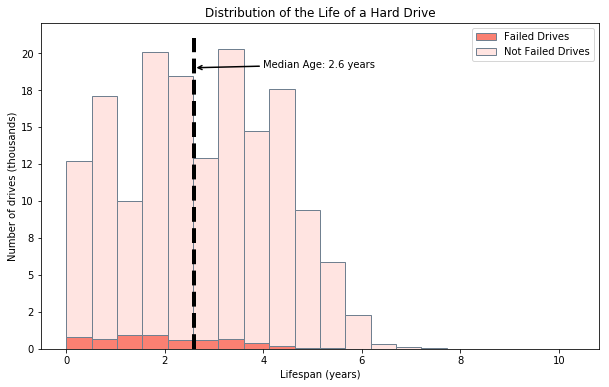

In [41]:
plt.figure(figsize=(10,6))

plt.hist([df_fails.drive_age_in_years, df_lives.drive_age_in_years], stacked=True, bins=20,
         edgecolor='slategrey', color=['salmon', 'mistyrose'])

plt.title("Distribution of the Life of a Hard Drive")
plt.xlabel("Lifespan (years)")
plt.ylabel("Number of drives (thousands)")
plt.legend(["Failed Drives","Not Failed Drives"])
plt.vlines(2.6, 0, 21_000, linestyles='dashed',colors = 'black', linewidths=4)

ax = plt.gca()
ax.set_yticklabels(['{:.0f}'.format(x / 1000) for x in ax.get_yticks()])

#place arrow
plt.annotate(
    'Median Age: 2.6 years',
    xy=(2.6, 19_000),
    xytext=(4, 19_000),
    arrowprops={'arrowstyle': '->', 'linewidth':'1.5'})

plt.show()

#### How is this misleading?
- Failures include not only drives that have failed, but also drives that have yet to fail but show signs of failing soon. Our goal is to determine the reliability of hard drives. Therefore, it is acceptable to classify imminently failing drives as failures. 
- Failures do not take into account the lifespan of the hard drive. It is important to realize that all hard drives, given enough time, will eventually fail. For example, a typical lifespan of a hard drive is 5 years. If a hard drive fails after 10 years of continual operation, then it should have a reliable rating, as it lasted well past it's typical lifespan. Therefore, the focus will be on drives that fail before reaching their average lifespan. 

> We will identify hard drives that are more prone to early failures.  

### How do we define an early failure? 

The goal of the project is to determine which hard drives are more prone to early failures. Looking at the lifespan of all hard drives, a hard drive that fails within the first half of all life spans, is labeled as an early failure.

In [42]:
df[['drive_age_in_years']].describe()

,drive_age_in_years
count,161828.000000
mean,2.722680
std,1.524778
min,0.000000
25%,1.600000
50%,2.600000
75%,4.000000
max,10.300000


> A cut-off age of 2.6 years is utilized for early failure.

The `explore.early_failure` function creates a column in the dataframe that identifies drives that are early failures.

In [43]:
df = explore.early_failure(df)

### How do the SMART stats compare failed and non-failed drives? 

In [44]:
df.columns

Index(['serial_number', 'manufacturer', 'model', 'capacity_terabytes',
       'failure', 'drive_age_in_years', 'reallocated_sectors_count',
       'reported_uncorrectable_errors', 'command_timeout',
       'current_pending_sector_count', 'uncorrectable_sector_count',
       'early_failure'],
      dtype='object')

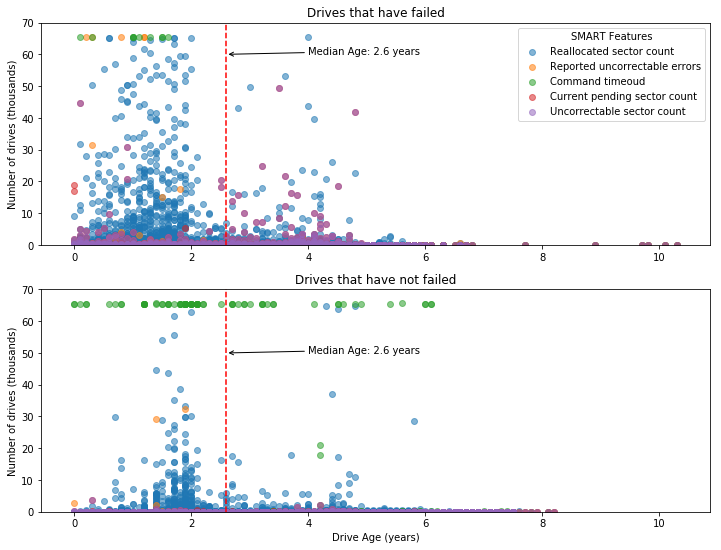

In [45]:
fig = plt.figure(figsize=(12,9))

#create subplot one
ax1 = plt.subplot(211)

#plot smart stats vs their lifespan
for col in df.columns[6:-1]:
    plt.scatter(y=df_fails[col], x=df_fails.drive_age_in_years, label=col, alpha = .55)
plt.legend(title = 'SMART Features', labels=['Reallocated sector count','Reported uncorrectable errors',
                                             'Command timeoud','Current pending sector count',
                                             'Uncorrectable sector count'])
plt.vlines(2.6, 0, 70_000, linestyles= "dashed", colors = 'red')
plt.ylim((0, 70_000))
plt.ylabel("Number of drives (thousands)")
plt.title('Drives that have failed')

#divide yticks by 1000 
ax1.set_yticklabels(['{:.0f}'.format(x / 1000) for x in ax1.get_yticks()])

#place arrow 
plt.annotate(
    f'Median Age: 2.6 years',
    xy=(2.6, 60_000),
    xytext=(4, 60_000),
    arrowprops={'arrowstyle': '->'})

#create subplot two
ax2 = plt.subplot(2, 1, 2, sharex=ax1)

#plot smart stats vs their lifespan
for col in df.columns[6:-1]:
    plt.scatter(y=df_lives[col], x=df_lives.drive_age_in_years, label=col, alpha = .55)
plt.vlines(2.6, 0, 70_000, linestyles='dashed',colors = 'red')
plt.ylim((0, 70_000))
plt.xlabel("Drive Age (years)")
plt.ylabel("Number of drives (thousands)")
plt.title("Drives that have not failed")

#divide yticks by 1000 
ax2.set_yticklabels(['{:.0f}'.format(x / 1000) for x in ax2.get_yticks()])


#place arrow
plt.annotate(
    'Median Age: 2.6 years',
    xy=(2.6, 50_000),
    xytext=(4, 50_000),
    arrowprops={'arrowstyle': '->'})

plt.show()

> It is seen for drives that have failed, their SMART stats are consistently much higher than drives that have not failed. Thus concluding that the five identified SMART stats are indicators of failure. 

In [46]:
(df.failure == 1).sum() / len(df)

0.03652643547470154

In [47]:
(df.early_failure == 1).sum() / len(df)

0.0246310897990459

#### Removing young non-failing hard drives

Hard drives that are currently functioning properly, but have not reached the established cut-off age will be removed from this analysis. These hard drives have not been powered on long enough to give significant stats of a reliable drive. The `explore.old_or_fail` function drops rows containing drives that have not failed and are not older than the cut off age (2.6 years).

In [48]:
df = explore.old_or_fail(df)

In [49]:
df.shape

(83940, 12)

> After defining early failures and removing young non-failing drives, the dataframe has 12 columns and 83,940 rows. The data can be further explored. 

### How many of the hard drives are identified as early failures?

In [50]:
df.early_failure.value_counts()

0    79954
1     3986
Name: early_failure, dtype: int64

In [51]:
(df.early_failure == 1).sum() / len(df)

0.04748629973790803

In [52]:
(df.failure == 1).sum() / len(df)

0.07041934715272814

> Only 4.7% of hard drives are identified as early failures after the removal of young non-failing drives.

> This number is higher than the previously identified percentage of failures, due to the dataframe changing and the removal of the young, healthy drives. 

### Do early failure rates vary by model number?

In [53]:
# aggegrate by early failure, drive age, and add a total count
agg_model = df.groupby(['model']).agg({'early_failure' : 'sum', 'model' : 'count', 'drive_age_in_years':'mean'})
agg_model.rename(columns={'early_failure':'early_failures', 'model':'total_drives', 'drive_age_in_years':'average_age_in_years'}, inplace=True)

# add an early failure rate column
agg_model['early_failure_rate_percent'] = agg_model['early_failures'] / agg_model['total_drives'] * 100
agg_model.sort_values('early_failures', ascending = False)

,early_failures,total_drives,average_age_in_years,early_failure_rate_percent
model,,,,
ST4000DM000,1498,34901,3.947474,4.292141
ST12000NM0007,1104,1104,1.046830,100.000000
ST8000NM0055,383,442,1.395249,86.651584
ST8000DM002,276,9928,3.018433,2.780016
HGST HMS5C4040BLE640,197,10920,3.511181,1.804029
...,...,...,...,...
WDC WD1600AAJB,0,6,4.366667,0.000000
WDC WD1600AAJS,0,100,5.147000,0.000000
ST1000LM024 HN,0,1,2.800000,0.000000


> When aggregating by model number, we see wide variance in hard drive age and early failure rates. 

### Which manufacturer produces the most early failures?

In [54]:
pd.crosstab(df.manufacturer, df.early_failure)

early_failure,0,1
manufacturer,,
Hitachi,31138,305
Seagate,46247,3451
Toshiba,374,146
Western Digital,2195,84


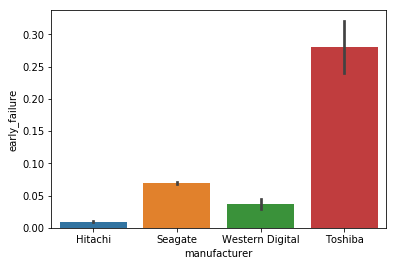

In [55]:
sns.barplot(df.manufacturer,df.early_failure)
plt.show()

> Of the four manufacturers being analyzed, Toshiba produces significantly more early failures.

#### Break down each manufacturer's failure rate by quarter

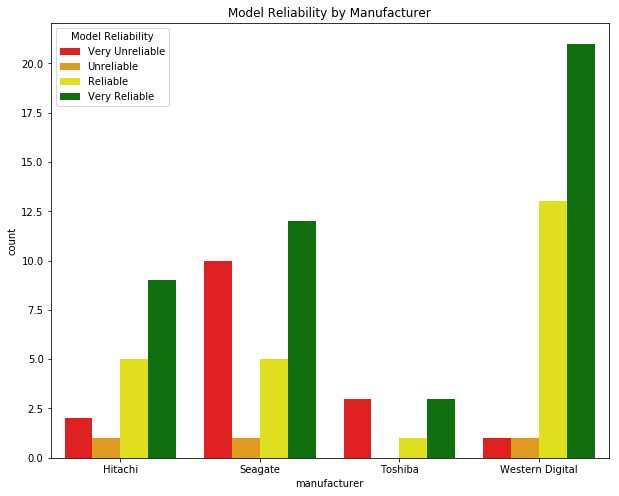

In [56]:
#models by quartile by manufacturer
explore.get_manufacturer_graph(df)

### Does drive capacity size correlate with early failure rates? 

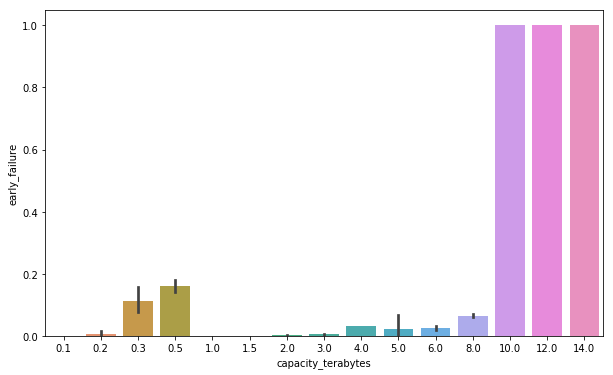

In [57]:
plt.figure(figsize=(10,6))
sns.barplot(df.capacity_terabytes,df.early_failure)
plt.show()

> Early failure rate dramatically increases in drives that have a 10 - 14 terabytes capacity.

### How do SMART attributes correlate with early failure?

The five SMART stats being presented count the occurrence of different types of errors that can occur in hard drives. For each type a count of above zero indicates that a hard drive should be replaced quickly due to a risk of failure.

In [58]:
smart_stats_5 = df.columns[6:11]
smart_stats_5

Index(['reallocated_sectors_count', 'reported_uncorrectable_errors',
       'command_timeout', 'current_pending_sector_count',
       'uncorrectable_sector_count'],
      dtype='object')

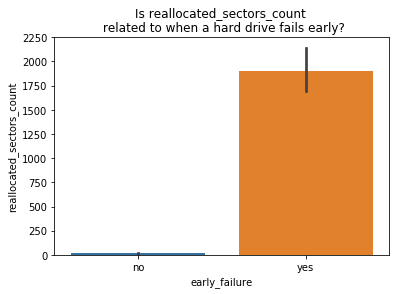

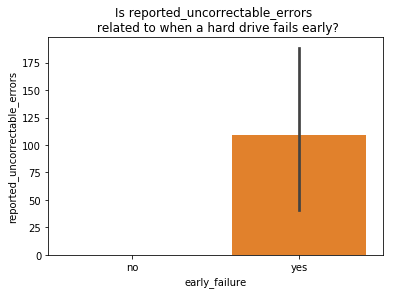

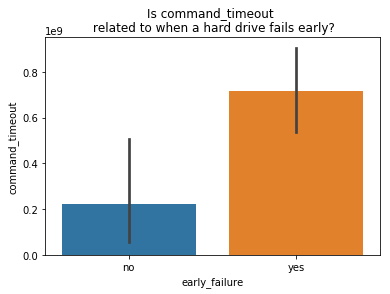

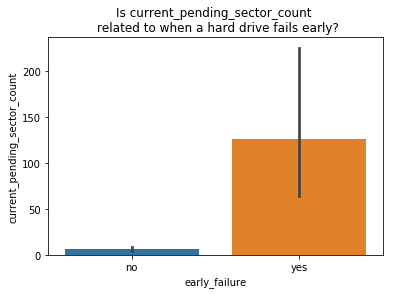

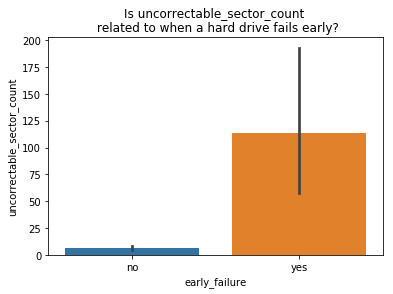

In [59]:
for stat in smart_stats_5:
    sns.barplot(df.early_failure,df[stat])
    plt.title("Is {} \n related to when a hard drive fails early?".format(stat))
    plt.xticks([0,1],["no","yes"])
    plt.show()

> Because these errors occur far more frequently in early failures than in non-early failures, all of these SMART seem to be a good indicator for early failures. 

#### SMART stats binary values

The five SMART stats utilized in this analysis are all counters:
- reallocated_sectors_count: counts the sectors that have been found and revamped
- reported_uncorrectable_errors: counts the errors that couldnt be recovered using hardware
- command_timeout: counts the aborted operations due to timeout
- current_pending_sector_count: counts the number of unstable sectors
- uncorrectable_sector_count: counts the uncorrectable errors when reading/writing sector

In [60]:
df.groupby('early_failure').sum()[smart_stats_5]

,reallocated_sectors_count,reported_uncorrectable_errors,command_timeout,current_pending_sector_count,uncorrectable_sector_count
early_failure,,,,,
0,1508120.0,19489.0,1.771718e+13,494078.0,490643.0
1,7587344.0,434002.0,2.860500e+12,504772.0,453491.0


When any of these SMART stats are anything other than zero, this is a bad sign for the hard drive, regardless of the counter. Therefore, the `explore.make_binary_values` function will look at these columns, and if any contain a value greater than zero, it is replaced with a boolean True or False. This simplfies the columns visuals, and will also make it simplier to feed into final algorithms. 

In [61]:
# Make features binary
df = explore.make_binary_values(df)

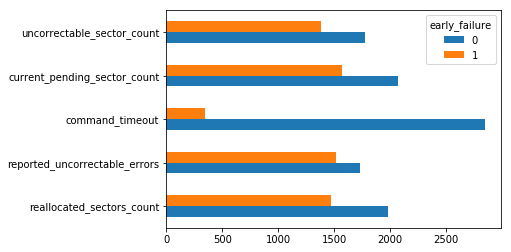

In [62]:
df.groupby('early_failure').sum()[smart_stats_5].T.plot.barh()
plt.show()

>Even though the non-early-failure hard drives have more SMART stats triggered in each column, it must be noted that the only 4.7% of all hard drives are early failures. So in comparison, the high count of SMART stats is significant. 

### Does the hard drive model affect the early failure rate?

The `explore.chi2_models` function determines if a model is independent of the early fail rate by using a chi squared test. 
> H0: the hard drive model is independent of early failure rate

In [63]:
df_stat = explore.chi2_models(df)
df_stat

,model,chi2,p,signif
0,Hitachi HDS5C4040ALE630,132.6020,0.0000,True
1,ST4000DM000,27.3500,0.0000,True
2,Hitachi HDS5C3030ALA630,238.1687,0.0000,True
3,ST8000DM002,95.9810,0.0000,True
4,HGST HMS5C4040BLE640,239.8896,0.0000,True
...,...,...,...,...
83,ST3500320AS,4.5272,0.0334,True
84,WDC WD3200AAKS,4.5272,0.0334,True
85,Hitachi HDS724040ALE640,1.8135,0.1781,False
86,WDC WD2500AAJB,4.5272,0.0334,True


> The models that have True in the 'signif' column have failed to reject the null hypothesis. Therefore, it cannot be said that these models are independent of early failure rates. 

In [64]:
# create a list of all the significant models
signif_models = list(df_stat [df_stat.signif == True].model)

In [65]:
len(signif_models)

54

> There are 54 models that are statistically significant in determining early failure. The following shows their value counts. 

In [66]:
df.model [df.model.isin(signif_models)].value_counts()

ST4000DM000                34901
HGST HMS5C4040BLE640       10920
ST8000DM002                 9928
HGST HMS5C4040ALE640        7673
Hitachi HDS5C3030ALA630     4540
Hitachi HDS722020ALA330     4482
Hitachi HDS5C4040ALE630     2639
ST6000DX000                 1890
ST12000NM0007               1104
Hitachi HDS723030ALA640      995
ST500LM012 HN                603
ST8000NM0055                 442
WDC WD5000LPVX               332
WDC WD10EADS                 287
ST31500541AS                 264
TOSHIBA MQ01ABF050           249
ST4000DX000                  173
TOSHIBA MD04ABA400V          147
WDC WD1600AAJS               100
ST320LT007                    73
HGST HUH728080ALE600          57
ST4000DM001                   34
ST500LM030                    28
HGST HUH721212ALN604          25
TOSHIBA MQ01ABF050M           19
ST10000NM0086                 14
TOSHIBA MG07ACA14TA           11
WDC WD20EFRX                   6
ST12000NM0117                  5
ST4000DM005                    5
ST250LT007

The `explore.model_scores` function takes the statistically significant models and determines a realiably score for them of them. 
- This is done by looking at the number of unique serial numbers for each model, and calculated a percentage of how many of them live and fail during the first quartile, the second quartile, the third quartile, and the fourth quartile. Each value is given a different weight based on the positiviy of longevity and negativity based on early failures.
- Only models with at least 10 unique serial numbers will be classified

In [67]:
# determine statisically significant models with over 10 serial numbers
signif_models_over_10 = df [df.model.isin(signif_models)].model.value_counts() [df [df.model.isin(signif_models)].model.value_counts() > 10].index
signif_models_over_10

Index(['ST4000DM000', 'HGST HMS5C4040BLE640', 'ST8000DM002',
       'HGST HMS5C4040ALE640', 'Hitachi HDS5C3030ALA630',
       'Hitachi HDS722020ALA330', 'Hitachi HDS5C4040ALE630', 'ST6000DX000',
       'ST12000NM0007', 'Hitachi HDS723030ALA640', 'ST500LM012 HN',
       'ST8000NM0055', 'WDC WD5000LPVX', 'WDC WD10EADS', 'ST31500541AS',
       'TOSHIBA MQ01ABF050', 'ST4000DX000', 'TOSHIBA MD04ABA400V',
       'WDC WD1600AAJS', 'ST320LT007', 'HGST HUH728080ALE600', 'ST4000DM001',
       'ST500LM030', 'HGST HUH721212ALN604', 'TOSHIBA MQ01ABF050M',
       'ST10000NM0086', 'TOSHIBA MG07ACA14TA'],
      dtype='object')

In [68]:
# get the reliability score for each model
df_scores = explore.model_scores(df [df.model.isin(signif_models_over_10)])

In [69]:
df_scores.sort_values('score').sort_values('score',ascending=False).head(10)

,model,score
8,Hitachi HDS722020ALA330,1.486167
2,Hitachi HDS5C3030ALA630,1.485903
0,Hitachi HDS5C4040ALE630,1.482001
10,Hitachi HDS723030ALA640,1.480402
9,WDC WD10EADS,1.479094
16,ST31500541AS,1.471591
12,TOSHIBA MD04ABA400V,1.465986
18,WDC WD1600AAJS,1.370000
6,ST6000DX000,1.292593
7,HGST HMS5C4040ALE640,1.181937


In [70]:
df_scores.sort_values('score').sort_values('score',ascending=False).tail(10)

,model,score
13,TOSHIBA MQ01ABF050,-0.755020
23,ST320LT007,-0.849315
20,ST8000NM0055,-2.685520
22,TOSHIBA MQ01ABF050M,-3.368421
26,ST10000NM0086,-3.428571
14,ST12000NM0007,-3.606884
21,ST4000DM001,-4.000000
25,TOSHIBA MG07ACA14TA,-4.000000
15,HGST HUH721212ALN604,-4.000000
24,ST500LM030,-4.000000


> These are the top ten most reliable hard drives and the bottom ten least reliable hard drives.

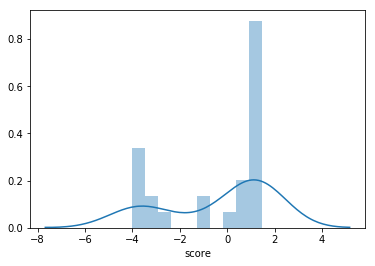

In [71]:
sns.distplot(df_scores.score, bins=10)
plt.show()

## Split

In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 83940 entries, 0 to 168960
Data columns (total 12 columns):
serial_number                    83940 non-null object
manufacturer                     83940 non-null object
model                            83940 non-null object
capacity_terabytes               83940 non-null float64
failure                          83940 non-null int64
drive_age_in_years               83940 non-null float64
reallocated_sectors_count        83940 non-null bool
reported_uncorrectable_errors    83940 non-null bool
command_timeout                  83940 non-null bool
current_pending_sector_count     83940 non-null bool
uncorrectable_sector_count       83940 non-null bool
early_failure                    83940 non-null int64
dtypes: bool(5), float64(2), int64(2), object(3)
memory usage: 8.0+ MB


The `model.split_my_data` function takes the dataframe and first splits by features and target. 
- For the features dataframe (X), the following columns are removed: 'failure', 'early_faliure', and 'drive_age_in_years'
- For the target dataframe (y), only the 'early_failure' column is retained

Next, the function splits each dataframe (X and y) into a train and test. 
- The train size is set as 80% 
- A random state is set at 123
- The early_failure is stratified, to ensure an even split between train and test

In [73]:
X_train, X_test, y_train, y_test = model.split_my_data(df)

In [74]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((67152, 7), (16788, 7), (67152, 1), (16788, 1))

In [75]:
X_train.head()

,manufacturer,capacity_terabytes,reallocated_sectors_count,reported_uncorrectable_errors,command_timeout,current_pending_sector_count,uncorrectable_sector_count
121424,Seagate,12.0,True,False,False,True,True
51821,Seagate,4.0,False,False,False,False,False
39076,Hitachi,4.0,False,False,False,False,False
139516,Hitachi,4.0,False,False,False,False,False
50771,Hitachi,4.0,False,False,False,False,False


The manufacturer column needs to be one hot encoded to be accepted by the classification models. The `model.encode_hot` function is used to one hot encode the manufacturer column and remove the original column.

In [76]:
# One hot encode manufacturer column
X_train, X_test = model.encode_hot(X_train, X_test, 'manufacturer')

In [77]:
X_train.head()

,capacity_terabytes,reallocated_sectors_count,reported_uncorrectable_errors,command_timeout,current_pending_sector_count,uncorrectable_sector_count,Hitachi,Seagate,Toshiba,Western Digital
121424,12.0,True,False,False,True,True,0.0,1.0,0.0,0.0
51821,4.0,False,False,False,False,False,0.0,1.0,0.0,0.0
39076,4.0,False,False,False,False,False,1.0,0.0,0.0,0.0
139516,4.0,False,False,False,False,False,1.0,0.0,0.0,0.0
50771,4.0,False,False,False,False,False,1.0,0.0,0.0,0.0


## Model - Train

The training dataset is prepared for the model selection phase in order to best predict the dependent early failure variable. There are ten attributes in the train dataset for modeling and they include the capacity terabytes, the 5 SMART stats, and the binary encoded 4 manufacters. 

This is a binary classification problem, therefore, Support Vector Machine, K-Nearest Neighbor, Logistic Regression, and Decision Tree algorithms will be used to solve this problem.

The 4 modeling functions: `model.knn_model`, `model.logit_model`, `model.dt_model`, `model.svc_model` perform the following 2 steps for training the algorithm and making predictions.

1. Training the algorithm - the fit method of the classifier is called to train the algorithm on the training data, which is passed as a parameter to the fit method.


2. Making predictions - to make predictions, the predict method of the classifier is used.

The `model.evaluate` function will return evaluation metrics.

- Evaluating the algorithm - Scikit-Learn's metrics library contains the classification_report and confusion_matrix methods, which can be readily used to find out the values for these important metrics.
- Due to the high cost of an early hard drive failure, the number of false negatives needs to be minimized, aka if a hard drive fails early, that needs to be properly predicted. However, a reasonable accuracy rate must be maintained, as well. 

### K-Nearest Neighbor

- The K-Nearest Neighbor classifier with the hyperparameters: n_neighbors = 3, weights = 'distance'

In [78]:
y_pred_knn, y_pred_test_knn = model.knn_model(X_train, y_train, X_test)

In [79]:
model.evaluate(y_train, y_pred_knn)

[[63526   437]
 [ 1715  1474]]

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     63963
           1       0.77      0.46      0.58      3189

    accuracy                           0.97     67152
   macro avg       0.87      0.73      0.78     67152
weighted avg       0.96      0.97      0.96     67152



> While KNN has a high accuracy score of 0.97, the recall rate for early failures is very low at 0.46. This is not ideal.

### Logistic Regression

- The Logistic Regression classifier with the hyperparamaters: solver = 'liblinear', class_weight = 'balanced', random_state = 123

In [80]:
y_pred_logit, y_pred_test_logit = model.logit_model(X_train, y_train, X_test)

In [81]:
model.evaluate(y_train, y_pred_logit)

[[53370 10593]
 [  647  2542]]

              precision    recall  f1-score   support

           0       0.99      0.83      0.90     63963
           1       0.19      0.80      0.31      3189

    accuracy                           0.83     67152
   macro avg       0.59      0.82      0.61     67152
weighted avg       0.95      0.83      0.88     67152



> The recall rate increases drastically to 0.80. However, it is seen that the accuracy falls to 0.83 and the number of false positives in the confusion matrix is over 10,000. This is still not ideal.

### Decision Tree

- The Decision Tree classifier with the hyperparameters: criterion = 'entropy', class_weight = 'balanced', max_depth = 6, random_state = 123

In [82]:
y_pred_dt, y_pred_test_dt = model.dt_model(X_train,y_train, X_test)

In [83]:
model.evaluate(y_train, y_pred_dt)

[[60327  3636]
 [  791  2398]]

              precision    recall  f1-score   support

           0       0.99      0.94      0.96     63963
           1       0.40      0.75      0.52      3189

    accuracy                           0.93     67152
   macro avg       0.69      0.85      0.74     67152
weighted avg       0.96      0.93      0.94     67152



> This has a much better balance of recall and accuracy. The recall rate is 0.75 and the accurary is 0.93. This is an ideal model. 

### Support Vector Machine

- The Support Vector Machine classifier with the hyperparameters: kernal = 'rbf', class_weight = 'balanced', random_state = 123

In [84]:
y_pred_svc, y_pred_test_svc = model.svc_model(X_train, y_train, X_test)

In [85]:
model.evaluate(y_train, y_pred_svc)

[[60289  3674]
 [  765  2424]]

              precision    recall  f1-score   support

           0       0.99      0.94      0.96     63963
           1       0.40      0.76      0.52      3189

    accuracy                           0.93     67152
   macro avg       0.69      0.85      0.74     67152
weighted avg       0.96      0.93      0.94     67152



> This performs almost identical to the decision tree, with an identical accuracy rate of 0.93 and a slightly higher recall rate of 0.76. This is the most ideal model.

> The Support Vector Machine model had the best combination of Accuracy, Recall, and Macro Average metrics. This is selected as our final model. 

## Model - Test

In order to determine if the final model did not overfit the data, the test data will be used to predict early failure. 

### Support Vector Machine

In [86]:
model.evaluate(y_test, y_pred_test_svc)

[[15077   914]
 [  191   606]]

              precision    recall  f1-score   support

           0       0.99      0.94      0.96     15991
           1       0.40      0.76      0.52       797

    accuracy                           0.93     16788
   macro avg       0.69      0.85      0.74     16788
weighted avg       0.96      0.93      0.94     16788



> This classifier maintained it's accuracy of 0.93 and recall rate for early failures of 0.76. This concludes that our model did not overfit the data. 

## Analysis

### Does reliability vary based on data capacity?

Yes. 

A hard drive's data capacity can have a profound effect on the reliability of that model. Models that have less than 10 terabytes of capacity do not show a strong relationship between capacity and life span. All of the hard drives in the data set that have a 10 terabyte capacity or greater were early failures. It is tempting to conclude from this that the reliability of a hard drive declines sharply if it has a 10 terabyte capacity or greater. However, we must keep in mind that because hard drives with larger capacities are generally new, these results may be due to those drives not yet being old enough to show in our data. Also worth noting, is there were only a hand full of drives that had 10 or 14 terabyte capacities most of the drives in the 10-14 terabyte range were 12 terabyte drives.

### Does reliability vary by manufacturer?

Yes.

Manufacturers vary in terms of the reliability of the hard drives they produce. We looked at the median value of each model produced by a given manufacturer and assigned each a value based on which quartile the model fell into when looking at the ages of all of the hard drives in the data set. Based on that information here are how the manufacturer rank in terms of hard drive reliability.
 
1) Western Digital
 
Western Digital has the highest volume of models that fell into the 3rd and 4th quartile and very few that fell into 1st or 2nd, which was our cutoff for early failures. This demonstrates consistent quality over a large volume of models and is why we ranked Western Digital as number 1 in terms of reliability. They provide a large variety of hard drive models, which consistently last above the average lifespan.
 
2) Hitachi
 
The reliability of Hitachi’s models is very similar to Wester Digital. However, the volume of unique hard drive models that Hitachi has produced does not match that of Western Digital. In that way they do not show the same amount of consistency Western Digital has, which places them second. However, Hitachi shouldn't be penalized due to a small variety of models utilized by Backblaze. 

3) Seagate
 
A great majority of Seagate models fall either in the 1st or 4th quartile. This means any given model could be either very good or a very bad one. This places Seagate third on our list.
 
4) Toshiba
 
Like Seagate, Toshiba units are hit or miss, and they have a significantly lower volume of units than the other three manufacturers. This places Toshiba in 4th place.

### Does reliability vary between models?

Yes.

Reliability does vary between model types. We assigned each drive a reliability score based on its age and whether or not it completed its full life span within the time the data was collected. The reliability scores range from 1.5 to -4.0.
 
The top and bottom performing models are:

    Top Performing Models:    	      Reliability Score:
 
    Hitachi HDS722020ALA330                   1.486
    Hitachi HDS5C3030ALA630                   1.485
    Hitachi HDS5C4040ALE630                   1.482
    Hitachi HDS723030ALA640                   1.480
    WDC WD10EADS                              1.479
    ST31500541AS                              1.471

    Bottom Performing Models:	      Reliability Score:
 
    ST500LM030                               -4.000
    HGST HUH721212ALN604                     -4.000
    TOSHIBA MG07ACA14TA                      -4.000
    ST4000DM001                              -4.000
    ST12000NM0007                            -3.606
    ST10000NM0086                            -3.428

### Limitations of the Data

The age of hard drives in this study were taken at the end of the third quarter of 2019, so some of the drives in this study could have an older age than we could capture in the study.
 
If a hard drive’s age was below our cut off and it had not failed as of that time, the drive was dropped from the study. We did so to avoid labeling a drive as unreliable if it had not completed its entire lifespan.
 
The data presented is only on hard drives that were used by Backblaze, and may be misleading if generalized outside of that context. 
